# Import Data

In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

train_df = pd.read_csv('../../input/feedback-prize-effectiveness/train.csv')
stack_df = pd.read_csv('../../99_Ensemble/99_v1_03/result/stack_99_v1_03_05.csv')

train_df = train_df[['discourse_id']].merge(stack_df, on='discourse_id', how='left')
print(train_df.shape)
train_df.head()

(36765, 31)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,Ineffective_0,Adequate_0,Effective_0,label,loss,...,Effective_4,Ineffective_5,Adequate_5,Effective_5,Ineffective_6,Adequate_6,Effective_6,Ineffective,Adequate,Effective
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0.001864,0.131125,0.009868,1,0.085691,...,0.003289,0.011671,0.129193,0.001993,0.008107,0.126729,0.008021,0.046517,0.915126,0.038357
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,0.007999,0.130910,0.003947,1,0.087332,...,0.002593,0.022810,0.117033,0.003014,0.016535,0.123868,0.002454,0.095348,0.879612,0.025040
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,0.020101,0.121164,0.001592,1,0.164698,...,0.001091,0.041657,0.099220,0.001980,0.044090,0.097612,0.001156,0.191747,0.793756,0.014497
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0.047771,0.093853,0.001233,1,0.420119,...,0.001222,0.048549,0.093130,0.001179,0.035375,0.105771,0.001712,0.238283,0.750827,0.010890
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0.035391,0.106863,0.000603,1,0.290297,...,0.000905,0.060683,0.081371,0.000803,0.053988,0.088208,0.000661,0.326052,0.666938,0.007010


# Features

# Data Split

In [2]:
from os.path import join as opj

class args:
    fold_path = '../../00_EDA/00_v2_07/result/'
    num_fold = 5
    
fold_path = args.fold_path
import joblib
print('load folds...')
trn_ids_list = joblib.load(opj(fold_path,f'trn_ids_list.joblib'))
val_ids_list = joblib.load(opj(fold_path,f'val_ids_list.joblib'))

load folds...


# Stacking

In [3]:
import matplotlib.pyplot as plt

def show_feature_importance(model):
    feature_importance = model.get_feature_importance()
    fi_df = pd.DataFrame({'importance':feature_importance, 'features':cols})
    fi_df = fi_df.sort_values('importance', ascending=True)

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(fi_df)),
            fi_df['importance'].values,
            tick_label=fi_df['features'].values)
    plt.xlabel('importance')
    plt.ylabel('features')
    plt.grid()
    plt.show()

In [4]:
cols = []
for col_name in ['Ineffective','Adequate','Effective']:
    cols += [col for col in train_df.columns if (col.startswith(col_name) and '_' in col)] 
    
num_models = len(cols) // 3
num_models

7

In [5]:
import catboost
params = {
    'random_state':45, 
    'n_estimators':20000,
    'loss_function':'MultiClass',
}

fold0 : CV=0.5727


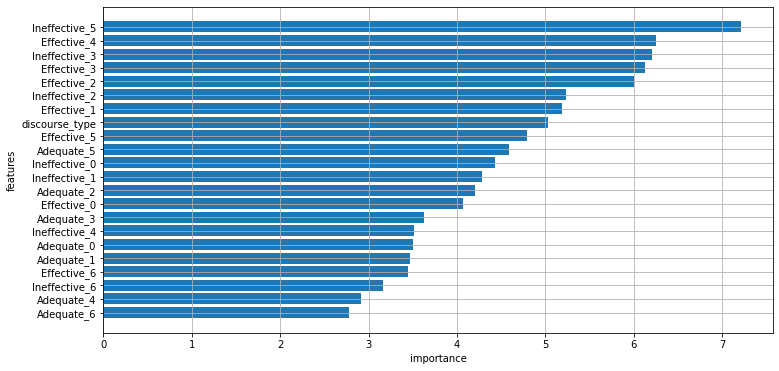

fold1 : CV=0.5855


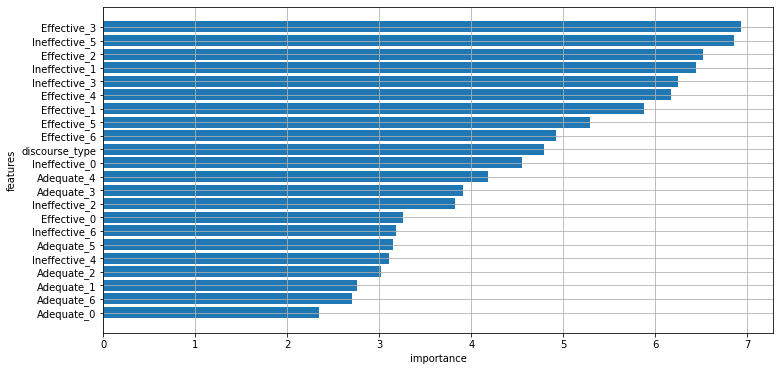

fold2 : CV=0.5714


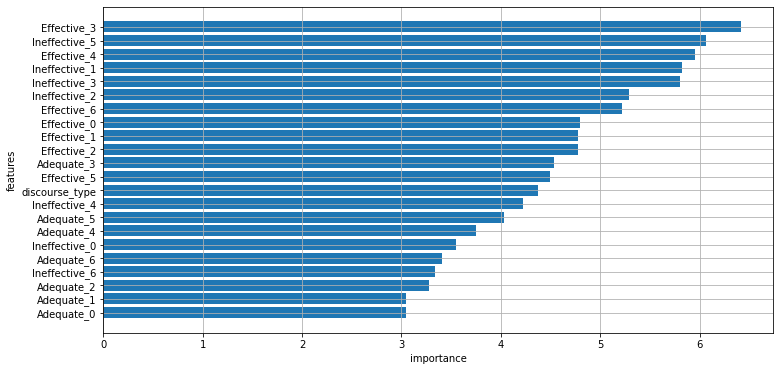

fold3 : CV=0.5914


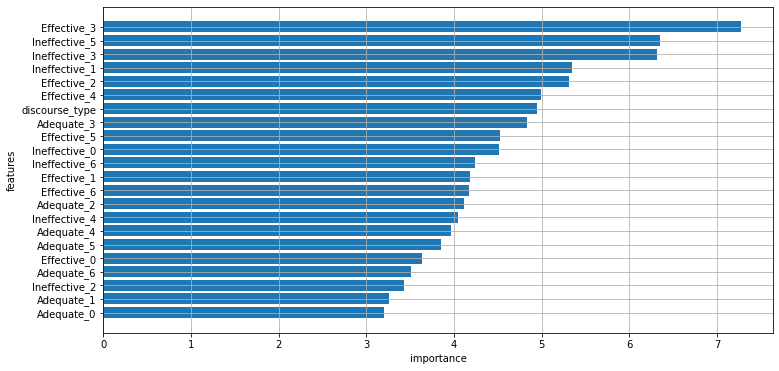

fold4 : CV=0.5788


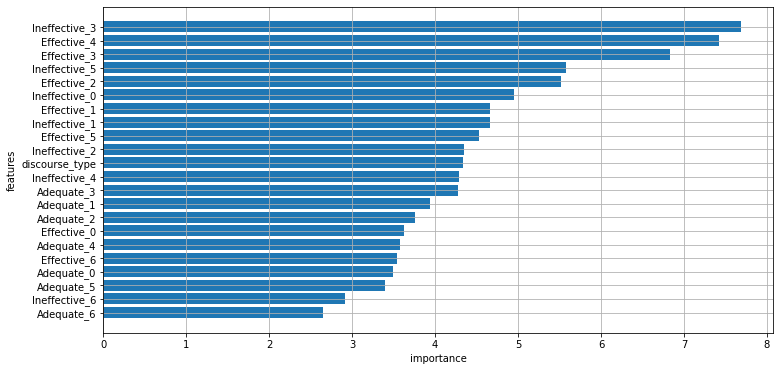

CV=0.5800


In [6]:
from sklearn.metrics import log_loss
import pickle
import os
os.makedirs('./result', exist_ok=True)

cols = ['discourse_type'] + cols
cat_features = [0]

score_list = []
oof_df = []
for fold in range(args.num_fold):
    trn_df = train_df[train_df['essay_id'].isin(trn_ids_list[fold])].reset_index(drop=True)
    val_df = train_df[train_df['essay_id'].isin(val_ids_list[fold])].reset_index(drop=True)

    pool_trn = catboost.Pool(trn_df[cols].values, label=trn_df['label'].values, cat_features=cat_features)
    pool_val = catboost.Pool(val_df[cols].values, label=val_df['label'].values, cat_features=cat_features)

    model = catboost.CatBoostClassifier(**params)
    model.fit(pool_trn, 
              eval_set=[pool_val], 
              verbose=0, 
              early_stopping_rounds=100,
             )

    pred = model.predict(pool_val, prediction_type='Probability')
    target = val_df['label'].values
    score = log_loss(target, pred, labels=[0,1,2])
    print('fold{} : CV={:.4f}'.format(fold, score))
    score_list.append(score)
    val_df['oof_ineffective'] = pred[:,0]
    val_df['oof_adequate'] = pred[:,1]
    val_df['oof_effective'] = pred[:,2]
    oof_df.append(val_df)
    # save model
    joblib.dump(model, f'./result/cat_fold{fold}.joblib')
    # plot
    show_feature_importance(model)
    
CV = sum(score_list) / len(score_list)
print('CV={:.4f}'.format(CV))

In [7]:
oof_df = pd.concat(oof_df).reset_index(drop=True)
oof_df = train_df[['discourse_id']].merge(oof_df, on='discourse_id', how='left')
oof_df.to_csv(f'./result/oof_cat.csv', index=False)
print(oof_df.shape)
oof_df.head()

(36765, 34)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,Ineffective_0,Adequate_0,Effective_0,label,loss,...,Effective_5,Ineffective_6,Adequate_6,Effective_6,Ineffective,Adequate,Effective,oof_ineffective,oof_adequate,oof_effective
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0.001864,0.131125,0.009868,1,0.085691,...,0.001993,0.008107,0.126729,0.008021,0.046517,0.915126,0.038357,0.046243,0.906984,0.046773
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,0.007999,0.130910,0.003947,1,0.087332,...,0.003014,0.016535,0.123868,0.002454,0.095348,0.879612,0.025040,0.101504,0.864483,0.034013
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,0.020101,0.121164,0.001592,1,0.164698,...,0.001980,0.044090,0.097612,0.001156,0.191747,0.793756,0.014497,0.186551,0.797583,0.015866
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0.047771,0.093853,0.001233,1,0.420119,...,0.001179,0.035375,0.105771,0.001712,0.238283,0.750827,0.010890,0.306687,0.683081,0.010232
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0.035391,0.106863,0.000603,1,0.290297,...,0.000803,0.053988,0.088208,0.000661,0.326052,0.666938,0.007010,0.331931,0.664384,0.003685


In [8]:
cols = [col for col in oof_df.columns if col.startswith('oof_')]

oof_score = log_loss(oof_df['label'].values, oof_df[cols].values, labels=[0,1,2])
print('oof={:.4f}'.format(oof_score))

oof=0.5800
